# State predictor

In [241]:
import pickle
from sklearn import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

ARRAY_SIZE = 4
MODEL_PREFIX = "H1_5"
SENSOR_LAG = 25
DATA_NAME = "H1_5_sil50_2D"

models = []

# Load the models (one for each sensor)
for i in range(ARRAY_SIZE):
  model = pickle.load(open(f'../models/{MODEL_PREFIX}_s{i}', 'rb'))
  models.append(model)
  print(model)


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linearregression', LinearRegression())])
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linearregression', LinearRegression())])
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linearregression', LinearRegression())])
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linearregression', LinearRegression())])


In [242]:
import os

# Load sensor data file including silicone
TF_file = f'../scripts/FT300-S_force_torque/data/{DATA_NAME}.csv'
sensor_file = f'../scripts/2x2_sensor/data/{DATA_NAME}.csv'

TFdata = pd.read_csv(os.path.join(os.getcwd(), TF_file))
sensordata = pd.read_csv(os.path.join(os.getcwd(), sensor_file))

for col in TFdata.columns:
  TFdata[col .split(' ')[0]] = TFdata[col]
  
for col in sensordata.columns:
  sensordata[col .split(' ')[0]] = sensordata[col]
  
print(sensordata.info())
print(TFdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   t_wall [s]  7194 non-null   float64
 1   X0 [uT]     7194 non-null   float64
 2   Y0 [uT]     7194 non-null   float64
 3   Z0 [uT]     7194 non-null   float64
 4   X1 [uT]     7194 non-null   float64
 5   Y1 [uT]     7194 non-null   float64
 6   Z1 [uT]     7194 non-null   float64
 7   X2 [uT]     7194 non-null   float64
 8   Y2 [uT]     7194 non-null   float64
 9   Z2 [uT]     7194 non-null   float64
 10  X3 [uT]     7194 non-null   float64
 11  Y3 [uT]     7194 non-null   float64
 12  Z3 [uT]     7194 non-null   float64
 13  t_wall      7194 non-null   float64
 14  X0          7194 non-null   float64
 15  Y0          7194 non-null   float64
 16  Z0          7194 non-null   float64
 17  X1          7194 non-null   float64
 18  Y1          7194 non-null   float64
 19  Z1          7194 non-null  

In [243]:
# Preprocessing
sensordata['t_wall'] -= SENSOR_LAG/1000

sensor_is_first = sensordata['t_wall'][0] < TFdata['t_wall'][0]
sensor_is_last = sensordata['t_wall'][len(sensordata)-1] > TFdata['t_wall'][len(TFdata)-1]

if sensor_is_first:
  start = TFdata['t_wall'][0]
else:
  start = sensordata['t_wall'][0]
  
if sensor_is_last:
  end = sensordata['t_wall'][len(sensordata)-1]
else:
  end = TFdata['t_wall'][len(TFdata)-1]
  
# Clip data to start at the same time and also to end at the same time
TFdata = TFdata[TFdata['t_wall'] >= start]
sensordata = sensordata[sensordata['t_wall'] >= start]
TFdata = TFdata[TFdata['t_wall'] <= end]
sensordata = sensordata[sensordata['t_wall'] <= end]

is_sensor_faster = len(sensordata) > len(TFdata)

combined = pd.concat([sensordata, TFdata], ignore_index=True, sort=False).sort_values(by=['t_wall'])

combined.set_index('t_wall')
combined = combined.apply(lambda x: x.interpolate(method='linear')).reset_index()

In [258]:
for i in range(ARRAY_SIZE):
  for letter in [f'X{i}', f'Y{i}', f'Z{i}']:
    combined[letter] -= np.mean(combined[letter][:100])
    combined[letter] /= 1000

In [259]:
for i in range(ARRAY_SIZE):
  combined[f'sens{i}_magnitude'] = np.sqrt(combined[f'X{i}']**2 + combined[f'Y{i}']**2 + combined[f'Z{i}']**2)
  combined[f'sens{i}_magnitude_XY'] = np.sqrt(combined[f'X{i}']**2 + combined[f'Y{i}']**2)

combined[f'TF_magnitude'] = np.sqrt(combined[f'F_x']**2 + combined[f'F_y']**2 + combined[f'F_z']**2)
combined[f'TF_magnitude_XY'] = np.sqrt(combined[f'F_x']**2 + combined[f'F_y']**2)

### Analysis
Some visualisations of the data

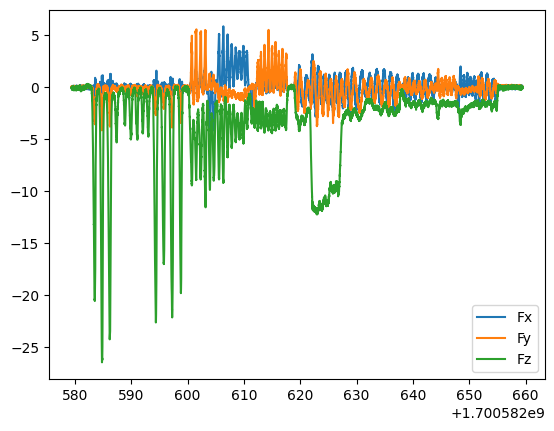

In [260]:
plt.plot(combined['t_wall'], combined['F_x'], label='Fx')
plt.plot(combined['t_wall'], combined['F_y'], label='Fy')
plt.plot(combined['t_wall'], combined['F_z'], label='Fz')
plt.legend()

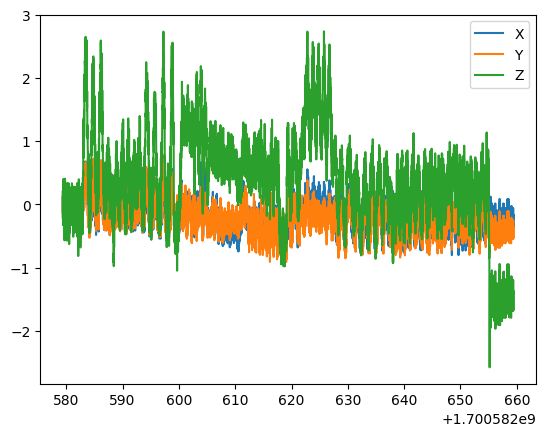

In [261]:
plt.plot(combined['t_wall'], combined['X0'], label='X')
plt.plot(combined['t_wall'], combined['Y0'], label='Y')
plt.plot(combined['t_wall'], combined['Z0'], label='Z')
plt.legend()

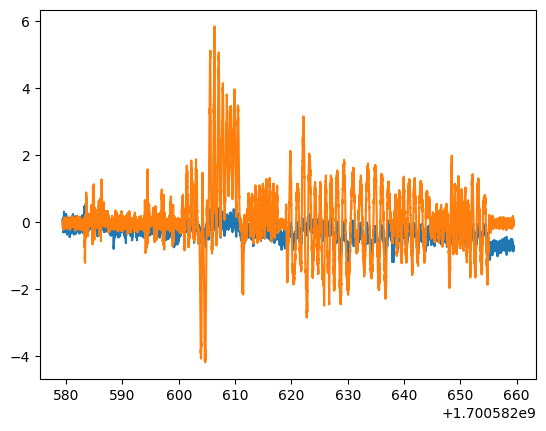

In [262]:
plt.plot(combined['t_wall'], combined['X1'])
plt.plot(combined['t_wall'], combined['F_x'], label='Fz')

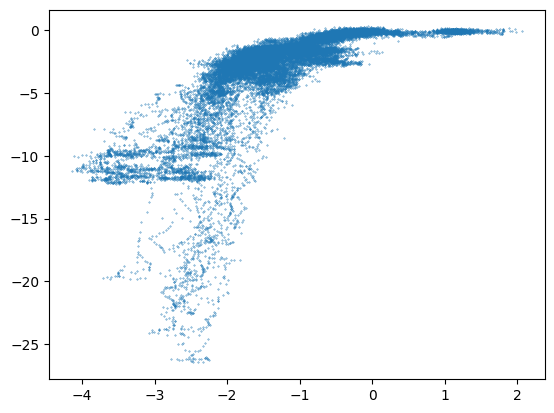

In [263]:
plt.scatter(combined['Z1'], combined['F_z'], s=0.1)
Bz = lambda z: 1/(-5.5-z)**3 * 5

zs = np.linspace(-4.5, 0, 100)

# plt.plot(zs, [Bz(z) for z in zs], color='red')

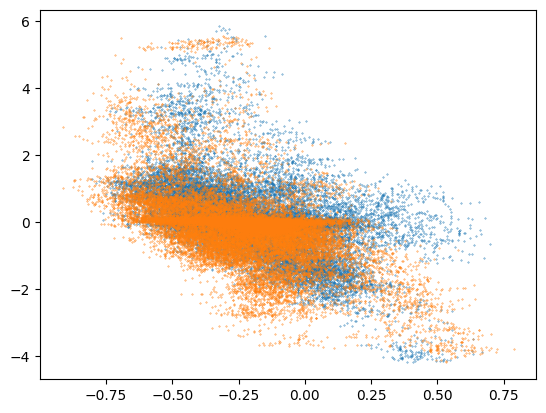

In [264]:
plt.scatter(combined['X0'], combined['F_x'], s=0.1)
plt.scatter(combined['Y0'], combined['F_y'], s=0.1)

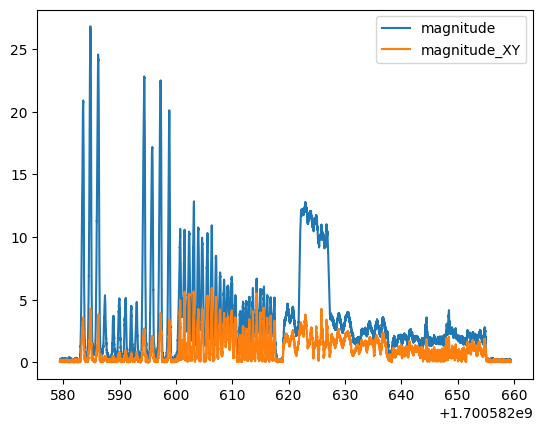

In [265]:
plt.plot(combined['t_wall'], combined['TF_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['TF_magnitude_XY'], label='magnitude_XY')
plt.legend()

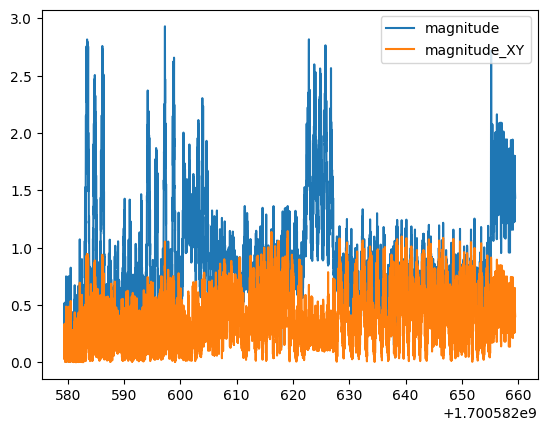

In [266]:
plt.plot(combined['t_wall'], combined['sens0_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['sens0_magnitude_XY'], label='magnitude_XY')
plt.legend()

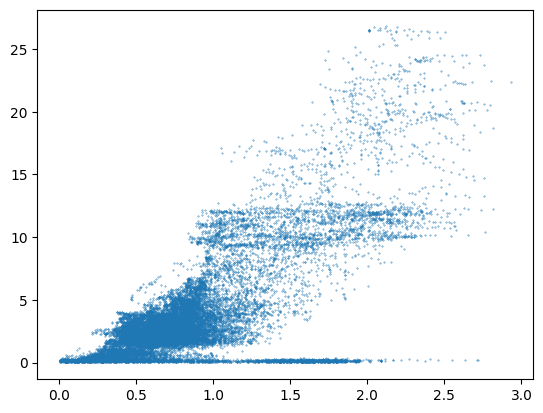

In [267]:
plt.scatter(combined['sens0_magnitude'], combined['TF_magnitude'], s=0.1)

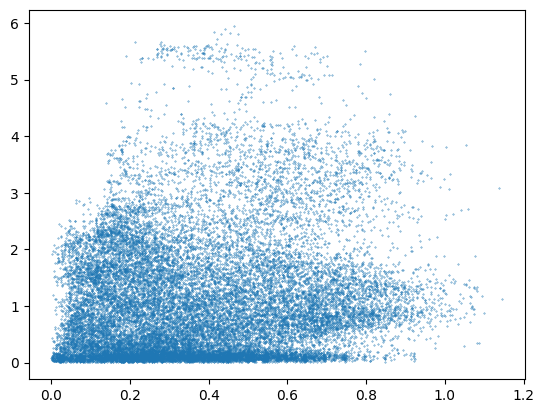

In [268]:
plt.scatter(combined['sens0_magnitude_XY'], combined['TF_magnitude_XY'], s=0.1)

# Prediction

In [275]:

# Predict forces
for i in range(ARRAY_SIZE):  
    features = np.array([combined[f'X{i}'], combined[f'Y{i}'], combined[f'Z{i}'], combined[f'sens{i}_magnitude'], combined[f'sens{i}_magnitude_XY']]).T
    features[np.isnan(features)] = 0 
    features[:, :] = 0

    Y = models[i].predict(features)

    # plot_predictions(Y, Y_pred)

    combined[f'F_x{i}'] = Y[:,0]
    combined[f'F_y{i}'] = Y[:,1]
    combined[f'F_z{i}'] = Y[:,2]

In [276]:
def plot_predictions(Y, Y_pred):
  
  subplot_index = Y.shape[1] * 100 + 11
  
  for i in range(Y.shape[1]):
    
    plt.subplot(subplot_index + i)
    plt.plot(Y[:,i], label='true')
    plt.plot(Y_pred[:,i], label='pred')

  plt.show()

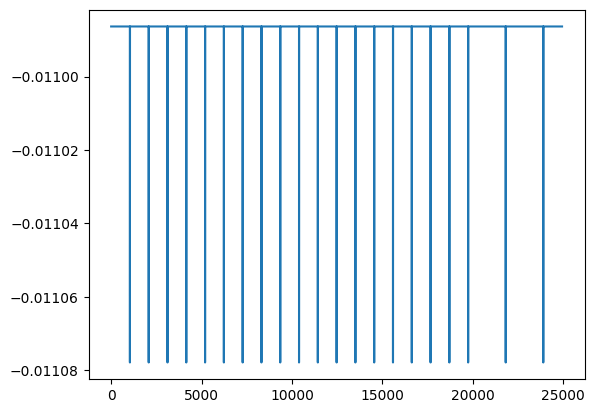

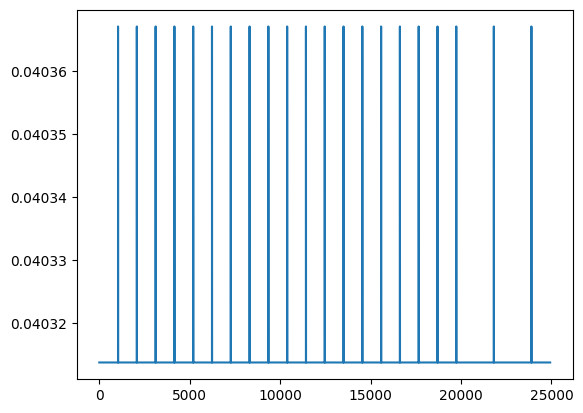

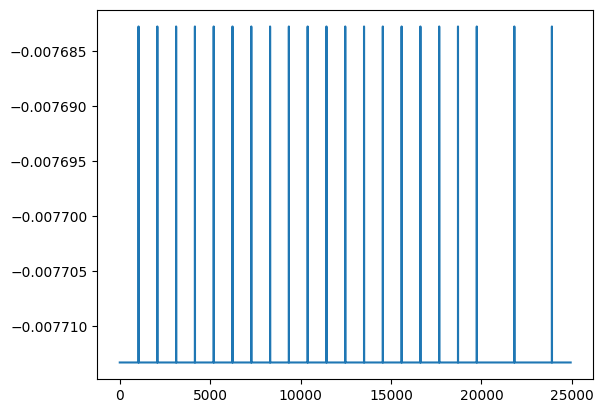

In [277]:
for letter in ['x', 'y', 'z']:
  # plt.plot(combined[f'F_{letter}'])
  plt.plot(combined[f'F_{letter}0']) #+ combined[f'F_{letter}1'] + combined[f'F_{letter}2'] + combined[f'F_{letter}3'])
  # plt.xlim(10000, 15000)
  # plt.ylim(-10, 10)
  plt.show()
  

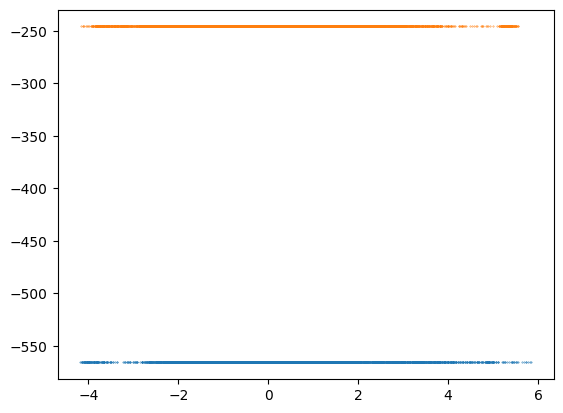

In [278]:
plt.scatter(combined['F_x'], combined['F_x0'] + combined['F_x1'] + combined['F_x2'] + combined['F_x3'], 0.1)
plt.scatter(combined['F_y'], combined['F_y0'] + combined['F_y1'] + combined['F_y2'] + combined['F_y3'], 0.1)

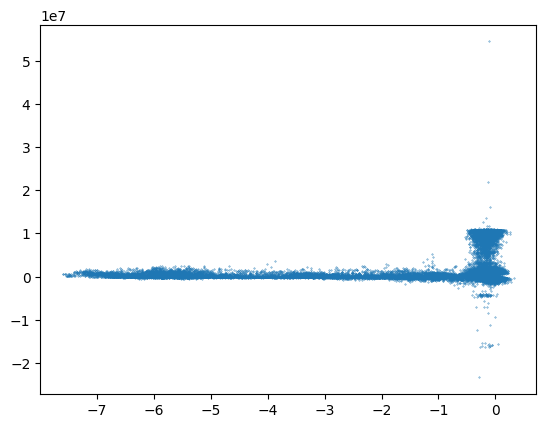

In [ ]:
plt.scatter(combined['F_z'], combined['F_z0'] + combined['F_z1'] + combined['F_z2'] + combined['F_z3'], 0.1)

In [ ]:
combined.to_csv('combined3.csv')